#### Загружаем библиотеки

In [4]:
# Загружаем библиотеки
from pathlib import Path
import os
import time
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

#### Блок 1. Подготовка технических данных для анализа

В данном блоке кода мы обрабатываем исторические данные (котировки), полученные с сайта Investing.com, для дальнейшего построения моделей предсказания цены акции.
В качестве исходных данных использованы котировки за период с 01.01.2012 по 02.06.2025:

- акции ПАО «Татнефть» (таргет),

- нефти марки Brent,

- индекс МосБиржи,

- индекс S&P 500,

- валютные пары USD/RUB и EUR/RUB.

Эти показатели были выбраны, так как они существенно влияют на котировки акций ПАО «Татнефть» (корреляционная матрица представлена в блоке 1.1). Несмотря на то, что согласно корреляционной матрице нефть марки Brent демонстрирует незначительное влияние на котировки акций ПАО «Татнефть», она всё же была включена в качестве признака, так как является фундаментальным индикатором при оценке акций компаний топливно-энергетического комплекса (ТЭК).

В данном блоке выполняются следующие операции с данными:

1. Очищаем числовые значения от лишних символов (%, запятые).

2. Преобразуем текстовые обозначения чисел (K, M, B — тысячи, миллионы, миллиарды) в числовой формат.

3. Приводим даты к единому формату datetime для корректного объединения датафреймов и работы моделей.

4. Обрабатываем колонку объёмов (Vol.):<br>

- если в колонке Vol. заполнено более 70 % значений — удаляем только строки с пропусками,<br>

- если данных в Vol. недостаточно — удаляем всю колонку.

In [5]:
# Папки 
input_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Сбор данных")
output_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Обработанные данные")
output_dir.mkdir(parents=True, exist_ok=True)

# Список файлов скачанных с investing.com для создания фичей. Во многих файлах столбец Vol. присутсвует, но данных в нем нет или почти нет 
file_actions = {
    "Brent Oil Futures Historical Data.csv": "drop_rows",
    "TATNEFT Stock Price History.csv": "drop_rows",
    "EUR_RUB Historical Data.csv": "drop_column",
    "MOEX Russia Index Historical Data.csv": "drop_column",
    "S&P 500 Historical Data.csv": "drop_column",
    "USD_RUB Historical Data.csv": "drop_column"
}

# Функция обработки одного CSV-файла с данными
def process_file(filename: str, action: str, date_format='%m/%d/%Y'):
    file_path = input_dir / filename
    df = pd.read_csv(file_path)

    # Преобразуем дату в вормат datetime для модели
    df['Date'] = pd.to_datetime(df['Date'], format=date_format, errors='coerce')

    # Очищаем все столбцы от лишних символов
    for col in df.columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(',', '', regex=False)
        df[col] = df[col].str.replace('%', '', regex=False)
        df[col] = df[col].str.replace('K', 'e3', regex=False)
        df[col] = df[col].str.replace('M', 'e6', regex=False)
        df[col] = df[col].str.replace('B', 'e9', regex=False)

    # Преобразуем строки в числа (если это возможно)
    df = df.apply(pd.to_numeric, errors='ignore')
    
    # Работа с колонкой Vol.
    if 'Vol.' in df.columns:
        if action == "drop_column":
            df.drop(columns=['Vol.'], inplace=True)
        elif action == "drop_rows":
            df = df[df['Vol.'].notna()]

    # Сохраняем обработанный файл
    output_path = output_dir / filename
    df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"Обработан: {filename}")

# Применяем обработку ко всем файлам
for filename, action in tqdm(file_actions.items(), desc="Обработка CSV-файлов"):
    process_file(filename, action)


Обработка CSV-файлов:  33%|████████████████████▋                                         | 2/6 [00:00<00:00,  5.27it/s]

Обработан: Brent Oil Futures Historical Data.csv
Обработан: TATNEFT Stock Price History.csv


Обработка CSV-файлов:  67%|█████████████████████████████████████████▎                    | 4/6 [00:00<00:00,  5.07it/s]

Обработан: EUR_RUB Historical Data.csv
Обработан: MOEX Russia Index Historical Data.csv


Обработка CSV-файлов:  83%|███████████████████████████████████████████████████▋          | 5/6 [00:00<00:00,  5.12it/s]

Обработан: S&P 500 Historical Data.csv


Обработка CSV-файлов: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.89it/s]

Обработан: USD_RUB Historical Data.csv


##### Блок 1.1. Корреляционная матрица основных признаков влияющих на цену акции ПАО "Татнефть"

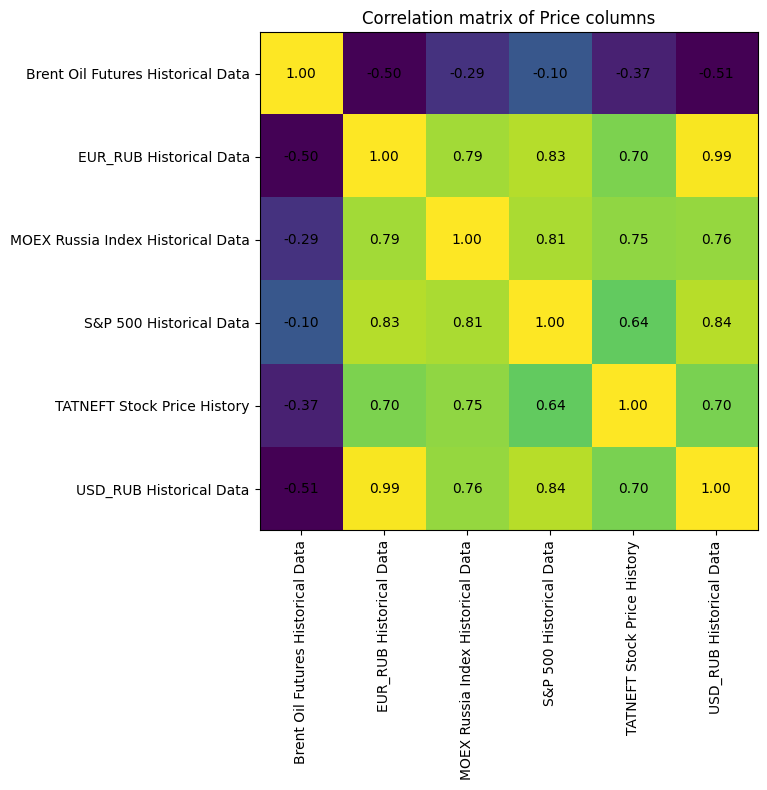

In [6]:
# Путь к папке
data_dir = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Обработанные данные"

# Собираем серии "Price" из всех файлов
series = {}
for fn in os.listdir(data_dir):
    if fn.lower().endswith(".csv"):
        df = pd.read_csv(os.path.join(data_dir, fn), parse_dates=["Date"])
        if "Price" in df.columns:
            name = os.path.splitext(fn)[0]
            series[name] = df.set_index("Date")["Price"]

# Конкатенация и корреляция
prices = pd.concat(series, axis=1).dropna()
corr = prices.corr()

# Визуализация через matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(corr.values)

# Метки
names = corr.columns.tolist()
ax.set_xticks(range(len(names)))
ax.set_yticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)

# Подписи значений
for i in range(len(names)):
    for j in range(len(names)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")

ax.set_title("Correlation matrix of Price columns")
fig.tight_layout()
plt.show()


#### Блок 2. Расчёт технических индикаторов и заполнение пропущенных значений

В данном блоке кода мы рассчитываем технические индикаторы по историческим котировкам, полученным с сайта Investing.com. Эти индикаторы широко используются в техническом трейдинге и помогают выявить скрытые закономерности в движении цены, такие как тренды, импульсы, уровни перекупленности/перепроданности и волатильность. Все вычисления производятся отдельно для каждого файла: нефть, валюты, индексы и акция ПАО «Татнефть».

В результате мы получаем дополнительные фичи для более точного предсказания нашего таргета. Помимо стандартных колонок (цена, максимум, минимум, объём) представлены более 20 новых признаков, которые будут использоваться в модели.

В данном блоке мы проводим следующие операции:

1. Для каждой строки рассчитываем скользящие средние (EMA) с разными окнами. EMA позволяют выявлять краткосрочные, среднесрочные и долгосрочные тренды, которые сглаживают ценовые колебания и позволяют лучше видеть направление движения рынка.
2. Рассчитываем индекс относительной силы (RSI), который помогает выявить зоны перекупленности и перепроданности, что помогает находить потенциальные точки разворота цены.
3. Рассчитываем индикатор схождения/расхождения скользящих средних (MACD). MACD сравнивает две скользящие средние и помогает определить силу, направление и возможный разворот текущего тренда.
4. Рассчитываем полосы Боллинджера (Bollinger Bands) и их ширину. Bollinger Bands помогают оценить волатильность рынка. Если полосы сужаются — это может означать, что рынок «затаился» и скоро начнётся движение. Если полосы расширяются — значит, волатильность растёт, и движение уже началось.
5. Рассчитываем средний истинный диапазон (ATR). ATR показывает средний диапазон колебаний цены за определённый период. Используется для оценки риска и волатильности — чем выше ATR, тем нестабильнее рынок.
6. Рассчитываем процентное изменение цены за определённый период (ROC). ROC позволяет выявить ускорения/замедления тренда и сигналы на вход/выход из позиции.
7. Рассчитываем уровни Фибоначчи, которые используются для оценки потенциальных уровней поддержки и сопротивления. Часто применяются трейдерами для постановки целей и стоп-лоссов.
8. При наличии колонки объёма рассчитываем накопленный объём торгов (OBV) и скользящую среднюю объёма. Эти показатели помогают выявить скрытые накопления или распродажи актива, которые не видны по цене.
9. После расчёта всех индикаторов мы заполняем пропущенные значения по числовым колонкам средними значениями.

В результате мы получаем очищенные и обогащённые техническими индикаторами исторические данные (в том числе по акции ПАО «Татнефть»), содержащие большое количество признаков, которые можно использовать для построения моделей машинного обучения и нейросетей.

In [7]:
# Функция расчёта тех. индикаторов
def add_technical_indicators(df):
    price = df['Price']  # цена закрытия
    high = df['High']    # максимум за день
    low = df['Low']      # минимум за день

    # EMA (экспоненциальные скользящие средние)
    df['EMA_5'] = price.ewm(span=5).mean()      # краткосрочная EMA
    df['EMA_14'] = price.ewm(span=14).mean()    # среднесрочная EMA
    df['EMA_50'] = price.ewm(span=50).mean()    # долгосрочная EMA

    # RSI (индекс относительной силы)
    delta = price.diff()                            # разница между текущей и предыдущей ценой
    gain = np.where(delta > 0, delta, 0)            # положительные изменения
    loss = np.where(delta < 0, -delta, 0)           # отрицательные изменения
    avg_gain = pd.Series(gain).rolling(14).mean()   # средний рост за 14 дней
    avg_loss = pd.Series(loss).rolling(14).mean()   # среднее падение за 14 дней
    rs = avg_gain / avg_loss                        # отношение роста к падению
    df['RSI_14'] = 100 - (100 / (1 + rs))           # итоговый RSI (перекупленность/перепроданность)

    # MACD (расхождение скользящих средних)
    ema12 = price.ewm(span=12).mean()                        # быстрая EMA
    ema26 = price.ewm(span=26).mean()                        # медленная EMA
    df['MACD'] = ema12 - ema26                               # основная MACD линия
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()        # сигнальная линия MACD
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']         # разница между линиями (сила сигнала)
    df['MACD_cross'] = df['MACD_diff'].apply(np.sign).diff() # смена знака — точка пересечения (вход/выход)

    # Bollinger Bands (полосы Боллинджера)
    sma20 = price.rolling(20).mean()                  # скользящая средняя за 20 дней
    std20 = price.rolling(20).std()                   # стандартное отклонение
    df['BB_upper'] = sma20 + 2 * std20                # верхняя граница
    df['BB_lower'] = sma20 - 2 * std20                # нижняя граница
    df['BB_width'] = df['BB_upper'] - df['BB_lower']  # ширина полос (волатильность)

    # ATR (средний истинный диапазон)
    tr1 = high - low                                     # диапазон дня
    tr2 = abs(high - price.shift())                      # разница high и предыдущей цены
    tr3 = abs(low - price.shift())                       # разница low и предыдущей цены
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)  # выбираем максимум из трёх
    df['ATR_14'] = tr.rolling(14).mean()                 # среднее значение за 14 дней

    # ROC (изменение цены в %)
    df['ROC_10'] = price.pct_change(10) * 100   # изменение цены за 10 дней в процентах

    # Уровни Фибоначчи (уровни поддержки/сопротивления)
    period = 14
    high_roll = high.rolling(period).max()      # максимум за период
    low_roll = low.rolling(period).min()        # минимум за период
    df['Fibo_23'] = high_roll - (high_roll - low_roll) * 0.236
    df['Fibo_38'] = high_roll - (high_roll - low_roll) * 0.382
    df['Fibo_50'] = high_roll - (high_roll - low_roll) * 0.5
    df['Fibo_61'] = high_roll - (high_roll - low_roll) * 0.618
    df['Fibo_78'] = high_roll - (high_roll - low_roll) * 0.786

    # Индикаторы объёма
    if 'Vol.' in df.columns and df['Vol.'].notna().sum() > 0:
        volume = df['Vol.'].fillna('0').replace({'K': 'e3', 'M': 'e6', 'B': 'e9'}, regex=True)   # заменяем обозначения 
        vol_numeric = volume.apply(lambda x: eval(x) if isinstance(x, str) and x.strip() else 0) # преобразуем в число
        direction = np.where(price.diff() > 0, 1, np.where(price.diff() < 0, -1, 0))             # направление движения цены
        df['OBV'] = (direction * vol_numeric).cumsum()                                           # кумулятивный объём
        df['Volume_MA_10'] = vol_numeric.rolling(10).mean()                                      # скользящая средняя объёма

    return df


# Пути
input_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Обработанные данные")
output_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Данные с индикаторами")
output_dir.mkdir(parents=True, exist_ok=True)  # создаём папку, если её нет

# Список файлов для обработки
files = [
    "Brent Oil Futures Historical Data.csv",
    "EUR_RUB Historical Data.csv",
    "MOEX Russia Index Historical Data.csv",
    "S&P 500 Historical Data.csv",
    "TATNEFT Stock Price History.csv",
    "USD_RUB Historical Data.csv"
]

# Расчёт индикаторов и заполнение NaN
for file in tqdm(files, desc="Индикаторы и NaN"):
    df = pd.read_csv(input_dir / file)
    df = add_technical_indicators(df)

    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()))

    new_name = file.replace(".csv", " with indicators.csv")
    df.to_csv(output_dir / new_name, index=False, encoding='utf-8-sig')
    print(f"Обработано и сохранено: {new_name}")

Индикаторы и NaN:  17%|███████████                                                       | 1/6 [00:00<00:01,  3.57it/s]

Обработано и сохранено: Brent Oil Futures Historical Data with indicators.csv


Индикаторы и NaN:  33%|██████████████████████                                            | 2/6 [00:00<00:01,  3.68it/s]

Обработано и сохранено: EUR_RUB Historical Data with indicators.csv


Индикаторы и NaN:  50%|█████████████████████████████████                                 | 3/6 [00:00<00:00,  3.72it/s]

Обработано и сохранено: MOEX Russia Index Historical Data with indicators.csv


Индикаторы и NaN:  67%|████████████████████████████████████████████                      | 4/6 [00:01<00:00,  3.71it/s]

Обработано и сохранено: S&P 500 Historical Data with indicators.csv


Индикаторы и NaN:  83%|███████████████████████████████████████████████████████           | 5/6 [00:01<00:00,  3.50it/s]

Обработано и сохранено: TATNEFT Stock Price History with indicators.csv


Индикаторы и NaN: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.63it/s]

Обработано и сохранено: USD_RUB Historical Data with indicators.csv


#### Блок 3. Объединение обработанных файлов в один DataFrame по дате и обработка NaN

В данном блоке кода мы объединяем все подготовленные исторические данные, полученные с сайта Investing.com, в один целостный DataFrame. Все входные таблицы предварительно дополнены техническими индикаторами и представляют разные аспекты финансового рынка. Это объединение позволяет сконцентрировать всю важную рыночную информацию в одном пространстве признаков — по каждой дате мы будем иметь полный контекст для анализа и предсказания движения акций.

В данном блоке мы проводим следующие операции:

1. Загружаем основной файл с котировками ПАО «Татнефть», так как он является центральным для анализа.
2. Последовательно присоединяем к нему остальные файлы по столбцу *Date*, используя *left join*. Таким образом, мы сохраняем все даты из основной таблицы и дополняем данными по основным котировкам и техническим индикаторам.
3. Чтобы избежать пересечений в названиях колонок, к каждому признаку из присоединяемых таблиц добавляется уникальный префикс — например, *Brent_Close*, *SP500_RSI_14*, *USD_RUB_MACD* и т. д.
4. После объединения заполняем все пропущенные значения в числовых колонках средними значениями по соответствующему столбцу. Это обеспечивает корректную работу моделей, для которых наличие `NaN` может быть критично.

В результате мы получаем единый, технически обогащённый и полностью очищенный DataFrame, содержащий синхронизированную информацию по всем ключевым экономическим индикаторам. Эти данные станут основой для построения моделей машинного обучения, нейросетей и предсказания направления цены акции.

In [8]:
# Папки с файлами
input_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Данные с индикаторами")  
output_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Объедененный ДФ")  
output_dir.mkdir(parents=True, exist_ok=True) # Создаём папку для сохранения, если она ещё не существует

# Задаём словарь с названиями файлов и соответствующими префиксами для всех колонок кроме даты
file_prefixes = {  
    "TATNEFT Stock Price History with indicators.csv": "TATNEFT",
    "Brent Oil Futures Historical Data with indicators.csv": "Brent",
    "EUR_RUB Historical Data with indicators.csv": "EUR_RUB",
    "MOEX Russia Index Historical Data with indicators.csv": "MOEX",
    "S&P 500 Historical Data with indicators.csv": "SP500",
    "USD_RUB Historical Data with indicators.csv": "USD_RUB"
}  

# Определяем основной файл (Татнефть), к которому будем присоединять остальные
main_file = "TATNEFT Stock Price History with indicators.csv"
main_df = pd.read_csv(input_dir / main_file, encoding='utf-8-sig')


for file, prefix in file_prefixes.items():  
    if file == main_file:
        continue
    df = pd.read_csv(input_dir / file, encoding='utf-8-sig')
    df = df.rename(columns={col: f"{prefix}_{col}" for col in df.columns if col != "Date"})
    main_df = pd.merge(main_df, df, on="Date", how="left")
    

numeric_cols = main_df.select_dtypes(include='number').columns
main_df[numeric_cols] = main_df[numeric_cols].apply(lambda col: col.fillna(col.mean()))

output_path = output_dir / "Объединенный DataFrame.csv"

main_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Объединённый DataFrame сохранён: {output_path.name}")


Объединённый DataFrame сохранён: Объединенный DataFrame.csv


#### Блок 4. Сбор, фильтрация и очистка новостей из Telegram-архива @markettwits

В данном блоке кода мы выполняем полную обработку новостных сообщений, экспортированных из Telegram-канала @markettwits, в формате HTML. Этот канал был создан 07.11.2017, и его архив охватывает весь период после этой даты. Сообщения из более раннего периода (до 06.11.2017) будут дополнительно собраны с сайта Rosinvest.com и обработаны отдельно. Для Telegram-архива парсинг HTML необходим, поскольку данные были экспортированы стандартными средствами Telegram без использования API.

В данном блоке мы проводим следующие операции:

1. Перебираем все HTML-файлы, содержащие экспортированные сообщения, и с помощью библиотеки *BeautifulSoup* извлекаем из них дату, время, текст и хэштеги.
2. Объединяем все полученные сообщения в единый DataFrame, строго сохраняя хронологию по дате.
3. Применяем фильтрацию по заранее заданным комбинациям хэштегов. Оставляем только те сообщения, которые содержат ключевые тематики, такие как #TATN, #нефть, #санкции, #инфляция, #отчетность и др.
4. Производим очистку текста сообщений — удаляем все хэштеги, эмодзи и посторонние символы, оставляя только содержательную часть сообщения. Это необходимо для корректной обработки текста на следующих этапах.
5. Преобразуем полученные данные в финальный формат и сохраняем очищенный и отфильтрованный набор новостей в CSV-файл.

В результате мы получаем структурированный, фильтрованный и очищенный набор новостных сообщений из Telegram, готовый для текстового анализа, извлечения признаков с помощью моделей типа RuBERT и дальнейшего использования в качестве входных данных для прогнозных моделей.

In [9]:
# Папки с файлами
folder_path = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Сбор данных\ChatExport_2025-07-08")
save_path = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\Собранные новости — очищенные.csv")

# Список для хранения сообщений
all_messages = []

# Обрабатываем HTML-файлы с прогресс-баром
html_files = list(folder_path.glob("*.html"))
for file in tqdm(html_files, desc="Обработка HTML-файлов"):
    with open(file, encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'html.parser')
    current_date = None

    for msg in soup.select('.message'):
        service_block = msg.select_one('.message.service .body')
        if service_block:
            try:
                parsed_date = pd.to_datetime(service_block.get_text(strip=True), format='%d %B %Y')
                current_date = parsed_date.strftime('%Y-%m-%d')
                continue
            except ValueError:
                continue

        time_tag = msg.select_one('.pull_right.date')
        text_tag = msg.select_one('.text')

        if time_tag and text_tag:
            msg_time = time_tag.get_text(strip=True)
            full_text = text_tag.get_text(separator=' ', strip=True)

            hashtags = [
                a.get_text(strip=True)
                for a in text_tag.select('a')
                if a.get('onclick', '').startswith('return ShowHashtag')
            ]
            hashtags_combined = ','.join(hashtags) if hashtags else ''

            all_messages.append({
                'date': current_date,
                'time': msg_time,
                'title': full_text,
                'hashtags': hashtags_combined
            })

df = pd.DataFrame(all_messages)                             # создаём DataFrame из списка сообщений
df['date'] = pd.to_datetime(df['date'], errors='coerce')

required_combinations = [                                   # список нужных сочетаний хэштегов
    {'#дкп', '#россия', '#прогноз'},
    {'#инфляциярф'},
    {'#инфляция', '#россия', '#опрос'},
    {'#TATN'},
    {'#TATN', '#дивиденд'},
    {'#TATN', '#отчетность'},
    {'#нефть', '#опек'},
    {'#нефть', '#прогноз'},
    {'#опек', '#нефть'},
    {'#нефть', '#россия', '#опек'},
    {'#санкции', '#россия'}
]

# Функция для проверки хэштегов
def has_required_combination(tag_string):                    
    if pd.isna(tag_string):
        return False
    tags = {tag.strip().lower() for tag in tag_string.split(',')}
    for combo in required_combinations:
        if combo.issubset(tags):
            return True
    return False

df = df[df['hashtags'].apply(has_required_combination)]     # фильтруем только релевантные новости

# Функция очистки текста от мусора
def clean_text(text):                                       
    if pd.isna(text):
        return ''
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^\w\s\.,!?%-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['title'] = df['title'].astype(str).apply(clean_text)     # применяем очистку к каждому сообщению
df.drop(columns=['hashtags'], inplace=True)                 # удаляем колонку с хэштегами

df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"Сохранено {len(df)} релевантных и очищенных сообщений в файл:\n{save_path}")


Обработка HTML-файлов: 100%|█████████████████████████████████████████████████████████| 324/324 [13:07<00:00,  2.43s/it]


Сохранено 11528 релевантных и очищенных сообщений в файл:
C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\Собранные новости — очищенные.csv


#### Блок 5. Парсинг, фильтрация и сохранение релевантных новостей с сайта Rosinvest за период 2012–2017 гг.

В данном блоке кода мы выполняем сбор и предварительную фильтрацию новостей с сайта Rosinvest.com за период с 01.01.2012 по 06.11.2017. Эти данные охватывают исторический отрезок до появления Telegram-канала @markettwits и необходимы для формирования полной хронологии новостного фона, так как котировки были выгружены начиная с 01.01.2012. В отличие от Telegram, здесь отсутствует готовый архив сообщений, поэтому сбор осуществляется путём парсинга веб-страниц архива новостей Rosinvest по дням.

В данном блоке мы проводим следующие операции:

1. Задаём временной диапазон новостей (от 2012 до 2017 года), директорию сохранения и шаблон ссылок для перехода к архиву за каждый конкретный день.
2. По каждой дате формируем ссылку на страницу архива и отправляем GET-запрос. При успешном ответе разбираем HTML-документ и извлекаем все новостные блоки с заголовками и временем публикации.
3. Добавляем искусственную задержку между запросами, чтобы избежать блокировки со стороны сайта.
4. Сохраняем все собранные заголовки в единый CSV-файл, содержащий дату, время и текст заголовка.
5. Переходим к фильтрации: оставляем только те новости, в которых встречаются ключевые слова — Татнефть, ОПЕК, Brent, ММВБ и т. д. Фильтрация осуществляется с помощью регулярных выражений, учитывающих разные формы написания.
6. Удаляем дубликаты заголовков и сохраняем финальный файл с отфильтрованными релевантными новостями в отдельный CSV-файл.

В результате получается чистый набор заголовков с сайта Rosinvest, охватывающий дополняющий период до 2017 года. Этот набор будет объединён с новостями, полученными с Telegram-канала @markettwits.

In [6]:
# Параметры парсинга
start_date = datetime(2012, 1, 1)
end_date = datetime(2017, 11, 6)

# Пути
save_dir = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\Новости росинвест") 
save_dir.mkdir(parents=True, exist_ok=True)

save_file = save_dir / "rosinvest_2012_2017.csv"

# Шаблон ссылки на страницу архива новостей за конкретный день
url_template = "https://rosinvest.com/novosti/archives/d/{}/"

news_data = []

# Основной цикл парсинга по датам
for date in tqdm(pd.date_range(start_date, end_date), desc="Парсинг Rosinvest"):
    date_str = date.strftime('%Y%m%d')
    url = url_template.format(date_str)

    try:
        response = requests.get(url, timeout=20)  # отправляем GET-запрос
        response.raise_for_status()               # проверяем, не вернул ли сервер ошибку
    except Exception as e:
        print(f"❌ Ошибка загрузки {url}: {e}")
        continue

    soup = BeautifulSoup(response.content, "html.parser")    # парсим HTML контент страницы
    news_blocks = soup.find_all("font", class_="arh-ulopt")  # находим блоки с новостями

    if not news_blocks:
        continue 

    for block in news_blocks:
        try:
            time_tag = block.find("font", class_="arh-yzo")  # вытаскиваем время публикации
            a_tag = block.find("a")                          # вытаскиваем заголовок новости

            if time_tag and a_tag:
                time_str = time_tag.text.strip()
                news_data.append({                      # добавляем новость в список
                    "date": date.strftime("%Y-%m-%d"),
                    "time": time_str,
                    "title": a_tag.text.strip()
                })
        except Exception as e:
            print(f"Ошибка при разборе блока на {url}: {e}")
            continue

    time.sleep(1.5)  # задержка между запросами для защиты от бана

# Сохраняем все спарсенные новости
df_ros = pd.DataFrame(news_data)
df_ros.to_csv(save_file, index=False, encoding='utf-8-sig')
print(f"\nСохранено {len(df_ros)} новостей Rosinvest в файл:\n{save_file}")

# Фильтрация релевантных новостей
input_file = save_file
output_file = save_dir / "rosinvest_2012_2017_релевантные.csv"

df = pd.read_csv(input_file, encoding='utf-8-sig')

if 'title' not in df.columns:
    raise ValueError("В файле отсутствует колонка 'title'.")

# Ключевые слова для фильтрации
keywords = [
    r'\bТатнефть\b',
    r'\bОПЕК\b',
    r'\bBrent\b',
    r'\bММВБ\b',
    r'\bиндекс ММВБ\b'
]

pattern = re.compile('|'.join(keywords), flags=re.IGNORECASE) # создаём шаблон регулярки по ключевым словам

# Применяем фильтрацию по заголовкам
df_filtered = df[df['title'].astype(str).apply(lambda x: bool(pattern.search(x)))]

df_filtered = df_filtered.drop_duplicates(subset='title') # удаляем дублирующиеся заголовки

df_filtered.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Сохранено {len(df_filtered)} релевантных новостей из Rosinvest в файл:\n{output_file}")


Парсинг Rosinvest: 100%|█████████████████████████████████████████████████████████| 2137/2137 [2:14:24<00:00,  3.77s/it]



Сохранено 189571 новостей Rosinvest в файл:
C:\Users\Администратор\Desktop\Аналитик данных\Дипломная работа\Текстовые данные\Новости росинвест\rosinvest_2012_2017.csv
Сохранено 1558 релевантных новостей из Rosinvest в файл:
C:\Users\Администратор\Desktop\Аналитик данных\Дипломная работа\Текстовые данные\Новости росинвест\rosinvest_2012_2017_релевантные.csv


#### Блок 6. Объединение новостей из Telegram и Rosinvest в единый CSV

В данном блоке мы объединяем релевантные и предварительно очищенные новостные сообщения, собранные из двух различных источников: Telegram-канала @markettwits и сайта Rosinvest за 2012–2017 годы. Это необходимо для формирования единого DataFrame текстов, на основе которого в дальнейшем будут извлекаться признаки и рассчитываться эмбеддинги с помощью модели RuBERT.

В данном блоке мы выполняем следующие операции:

1. Задаём пути к ранее сформированным CSV-файлам с отфильтрованными новостями из Telegram (*path_tg*) и Rosinvest (*path_ros*). Также указываем путь для сохранения итогового объединённого файла (*output_path*).
2. Загружаем оба файла в отдельные DataFrame’ы с указанием кодировки `utf-8-sig`, чтобы избежать проблем с кириллицей при чтении.
3. Проверяем, что в обоих источниках присутствуют необходимые колонки: *date*, *time*, *title*. В случае отсутствия хотя бы одной из них выбрасываем ошибку.
4. Объединяем оба источника новостей в один DataFrame с помощью `pd.concat`, не нарушая порядок строк.
5. Удаляем пустые строки и заголовки, содержащие только пробелы, чтобы исключить мусорные данные.
6. Преобразуем значения *date* и *time* в один столбец *datetime* и выполняем сортировку по убыванию — от самых новых к более старым новостям.
7. После сортировки удаляем временный столбец *datetime* и сохраняем итоговый файл в формате CSV с полной новостной лентой за весь период наблюдений.

В результате получаем структурированный и хронологически упорядоченный набор релевантных новостей, охватывающий период с 01.01.2012 года по 02.06.2025. Этот датасет будет использоваться как текстовая компонента при построении прогнозных моделей на основе RuBERT.

In [10]:
# Пути к файлам
path_tg = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\Собранные новости — очищенные.csv")
path_ros = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\Новости росинвест\rosinvest_2012_2017_релевантные.csv")
output_path = path_tg.parent / "все_релевантные_новости_объединено.csv" # путь, куда будет сохранён объединённый файл с новостями

# Загружаем Telegram новости
df_tg = pd.read_csv(path_tg, encoding='utf-8-sig')

# Загружаем Rosinvest новости
df_ros = pd.read_csv(path_ros, encoding='utf-8-sig')

# Проверяем наличие необходимых колонок
for df_name, df in [("Telegram", df_tg), ("Rosinvest", df_ros)]:
    if not all(col in df.columns for col in ['date', 'time', 'title']):
        raise ValueError(f"{df_name} — отсутствуют необходимые колонки ['date', 'time', 'title']")

# Объединяем обе таблицы в одну
df_all = pd.concat([df_tg, df_ros], ignore_index=True)

# Удаляем строки без заголовка
df_all = df_all[df_all['title'].notna() & (df_all['title'].str.strip() != '')]

# Преобразуем date + time в datetime для сортировки
df_all['datetime'] = pd.to_datetime(df_all['date'].astype(str) + ' ' + df_all['time'].astype(str), errors='coerce')

# Сортировка по убыванию
df_all = df_all.sort_values(by='datetime', ascending=False)

# Удаляем временный столбец
df_all = df_all[['date', 'time', 'title']]

# Сохраняем результат
df_all.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Объединено {len(df_all)} новостей из Telegram и Rosinvest.")
print(f"Сохранено в файл:\n{output_path}")

Объединено 13029 новостей из Telegram и Rosinvest.
Сохранено в файл:
C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\все_релевантные_новости_объединено.csv


#### Блок 7. Получение embeddings из текста с помощью RuBERT

В данном блоке мы выполняем преобразование текстов новостей в числовые эмбеддинги с помощью предобученной языковой модели RuBERT от Сбера. Полученные эмбеддинги впоследствии будут использованы в качестве входных признаков для построения прогнозных моделей.

В данном блоке мы выполняем следующие операции:

1. Задаём путь к файлу с объединёнными и отфильтрованными новостями (*input_path*) и указываем путь, по которому будут сохранены эмбеддинги (*output_path*).
2. Проверяем наличие доступного графического процессора (GPU) и, если он доступен, используем его для ускорения расчётов. В противном случае используется CPU.
3. Загружаем токенизатор и модель RuBERT (*sberbank-ai/ruBert-base*) с HuggingFace. Токенизатор преобразует текст в числовые токены, которые понятны модели. Модель переводим в режим предсказания и переносим на доступное устройство (GPU или CPU) для ускорения генерации эмбеддингов.
4. Загружаем тексты новостей из файла, приводим их к строковому типу и удаляем возможные пропущенные значения.
5. Выполняем дополнительную очистку текстов, а именно: удаляем ссылки, HTML-теги, управляющие символы, приводим текст к нижнему регистру и удаляем лишние пробелы, так как это снижает шум и повышает качество эмбеддингов.
6. Применяем функцию очистки ко всем новостным сообщениям, получая список подготовленных строк.
7. Для каждого текста вычисляем эмбеддинг, а именно: выполняем токенизацию, подаём токены в модель и извлекаем скрытое представление первого служебного токена (*CLS*), который несёт максимальную информацию о содержании всей новости в компактной форме.
8. Сохраняем все полученные эмбеддинги в отдельный DataFrame, где каждый столбец соответствует отдельному числовому признаку.
9. Объединяем эмбеддинги с исходными колонками даты и времени, исключая текстовую часть.
10. Сохраняем итоговый DataFrame с эмбеддингами в CSV-файл с кодировкой `utf-8-sig`.

В результате формируется готовый к использованию числовой набор признаков, отражающих семантику новостных сообщений. Этот набор можно напрямую использовать для обучения моделей машинного обучения и нейросетей.

In [11]:
# Пути к файлам
input_path = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\все_релевантные_новости_объединено.csv") 
output_path = input_path.parent / "новости_rubert_embeddings.csv" # путь, куда будут сохранены эмбеддинги

# Проверка на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

# Загружаем модель и токенизатор
model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# Загрузка новостей
df = pd.read_csv(input_path, encoding='utf-8-sig')
texts = df['title'].astype(str).fillna("").tolist()

# Функция очистки и приведения к нижнему регистру текста всех новостей
def clean_text_minimal(text):
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[\n\r\t\xa0]', ' ', text)
    text = text.lower()
    
    return text.strip()


texts_clean = [clean_text_minimal(t) for t in texts]  # применяем очистку ко всем новостям

# Генерация эмбеддингов
@torch.no_grad()  # отключаем подсчёт градиентов (ускоряет и экономит память)

# Функция, которая превращает текст в эмбеддинг
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().cpu().numpy()

# Обрабатываем все новости
all_embeddings = []

for text in tqdm(texts_clean, desc="Генерация эмбеддингов RuBERT"):
    emb = get_embedding(text)
    all_embeddings.append(emb)

# Формируем DataFrame с эмбеддингами
embedding_df = pd.DataFrame(all_embeddings, columns=[f"bert_{i}" for i in range(len(all_embeddings[0]))])

# Объединяем с исходной таблицей (без title)
df_out = pd.concat([df[['date', 'time']].reset_index(drop=True), embedding_df], axis=1)

# Сохраняем результат
df_out.to_csv(output_path, index=False, encoding='utf-8-sig')  
print(f"\nЭмбеддинги сохранены в файл:\n{output_path}")


Используется устройство: cuda


Генерация эмбеддингов RuBERT: 100%|██████████████████████████████████████████████| 13029/13029 [08:23<00:00, 25.88it/s]



Эмбеддинги сохранены в файл:
C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\новости_rubert_embeddings.csv


#### Блок 8. Объединение котировок и embeddings новостей

В данном блоке мы объединяем рыночные, макроэкономические и технические показатели с эмбеддингами новостей, полученными с помощью модели RuBERT. Это позволяет включить в итоговый DataFrame как числовые характеристики из котировок, так и текстовый новостной фон, агрегированный по дате. Такой подход необходим для построения прогностических моделей, учитывающих как поведение рынка, так и информационные сигналы.

В данном блоке мы выполняем следующие операции:

1. Приводим названия всех колонок в *df_quotes* к нижнему регистру для единообразия и предотвращения ошибок при объединении.
2. Преобразуем столбец *date* в обоих DataFrame’ах к формату *datetime*, чтобы объединение прошло корректно и не возникло ошибок.
3. Удаляем строки с некорректными датами в обоих DataFrame’ах, если такие имеются.
4. Агрегируем эмбеддинги новостей по дате: если в один день было несколько публикаций, их эмбеддинги усредняются, чтобы получить единственное представление текстового фона за день.
5. Объединяем два источника по дате с помощью *left join*, чтобы сохранить всю структуру по котировкам, а эмбеддинги добавлять только при наличии новостей.
6. Заполняем пропущенные значения в эмбеддингах нулями, если в какие-то дни не было публикаций.
7. Сохраняем итоговый объединённый DataFrame в CSV-файл для дальнейшего анализа и обучения моделей.

В результате получаем датасет, в котором каждый день представлен совокупностью рыночных и текстовых признаков — это позволит учитывать не только цифры, но и контекст новостного фона.

In [12]:
# Пути к файлам
path_quotes = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Объедененный ДФ\Объединенный DataFrame.csv")
path_bert = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\Текстовые данные\новости_rubert_embeddings.csv")
output_path = Path(r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\котировки_с_rubert.csv")

# Загружаем данные
df_quotes = pd.read_csv(path_quotes, encoding='utf-8-sig')
df_bert = pd.read_csv(path_bert, encoding='utf-8-sig')

# Приводим названия колонок к нижнему регистру чтобы объеденение прошло без ошибок
df_quotes.columns = [col.lower() for col in df_quotes.columns]

# Преобразуем даты к datetime чтобы объеденение прошло корректино и не возникло ошибок при обучении моделей
df_quotes['date'] = pd.to_datetime(df_quotes['date'], errors='coerce')
df_bert['date'] = pd.to_datetime(df_bert['date'], errors='coerce')

# Удаляем строки с некорректными датами
df_quotes = df_quotes[df_quotes['date'].notna()]
df_bert = df_bert[df_bert['date'].notna()]

# Усредняем эмбеддинги, если в один день было несколько новостей
df_bert_agg = df_bert.groupby('date').mean(numeric_only=True).reset_index()

# Объединяем котировки с эмбеддингами по дате (left join)
df_merged = pd.merge(df_quotes, df_bert_agg, on='date', how='left')

# Заполняем отсутствующие эмбеддинги нулями
bert_cols = [col for col in df_merged.columns if col.startswith('bert_')]
df_merged[bert_cols] = df_merged[bert_cols].fillna(0.0)

# Сохраняем итоговый файл
df_merged.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\nОбъединённый файл с котировками и эмбеддингами сохранён:\n{output_path}")



Объединённый файл с котировками и эмбеддингами сохранён:
C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\котировки_с_rubert.csv
